# core

> Core implementation of minion inspired by micrograd

In [1]:
#| default_exp core

In [2]:
#| hide
from nbdev.showdoc import *

In [110]:
#| export
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

In [111]:
#| hide
from minion.utils import draw_dot

In [112]:
%matplotlib inline

## Intuition around the Derivatives

### A simple python function example

Let's create a function and intuitively try to understand the derivate. We need to figure out intuitive sense of what derivates tells us about the function.

In [113]:
def f(x):
    return 3*(x**2) - 4*x + 5


f(4.0)

37.0

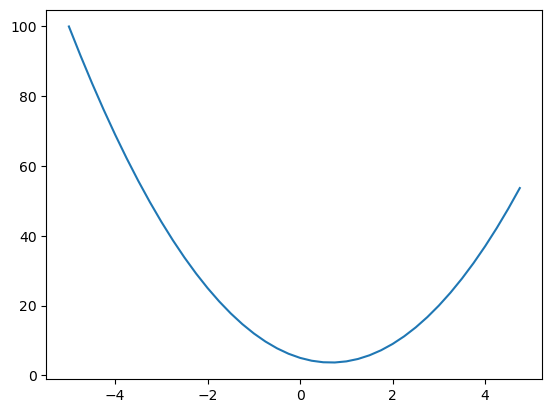

In [114]:
xs = np.arange(-5, 5, 0.25); xs
ys = f(xs); ys
plt.plot(xs, ys)

What's the derivative of function at the value 2. Looking at the plot we can see at x=2 if we nudge the function slightly it will increase. This implies derivative of function at 2 will be positive ( causing the function to increase). Similarily at -2 a slight increase in the value will cause the function to decrease. This intuitively indicates the derivative at -2 will be zero. Let's find out how it goes

In [115]:
h = 0.0000000000000000000000000000001 # A really small number
x1 = 2.0
y1 = f(x1); y1
x2 = x1+h
y2 = f(x2); y2

print(f"Approximate value of Derivative {(y2 -y1)/h}")

Approximate value of Derivative 0.0


Please note above procedure only calculates approximate numerical value of the derivate. Additionally, because of floating point rules we can't continuosly keep on decreasing the value of h. At some point it will give wrong answer

### Simple computation graph example

In [116]:
h = 0.01 
a = 2.0
b = -3.0 
c = 10.0
d = a*b+c; d


4.0

If we slightly nudge a. What will happen?

- Intuitively the value of the expression should decrease as a is multiplied by b which is a negative number. Therefore derivate of the function with respect to a will be negative. 
- By similar logic if we slightly nudge b. Since it's multiplied by a positive number a, value of the function/ expression will improve. Implies derivative of function w.r.t to b is positive.

Let's find out


In [117]:
h = 0.01 
a = 2.0
b = -3.0 
c = 10.0
a  = a+ h
d1 = a*b+c; d1

3.9700000000000006

In [118]:
print(f"Approximate value of Derivative w.r.t a {(d1-d)/h}")

Approximate value of Derivative w.r.t a -2.999999999999936


In [119]:
h = 0.01 
a = 2.0
b = -3.0 
c = 10.0
b  = b+ h
d1 = a*b+c; d1

4.02

In [120]:
print(f"Approximate value of Derivative w.r.t to b {(d1-d)/h}")

Approximate value of Derivative w.r.t to b 1.9999999999999574


## Implementation

Neural networks are big mathematical expressions. We need a Data Structure to hold such expressions together. We will define a `Value` object for the same with following properties

- It will hold scalar valued data
- Connection information keeping track of what values  contributed to current values
    - We define such values as child values inputed to our Value object as tuple but stored internally as set (for efficiency)
- Strings for what operations where performed on child values
- We also define some tools to visualize the value object / computation graph

In [261]:
#| export
class Value:

    '''Class to hold a scalar number in an object, references of input values/ computational graph for expression. Supports arthmetic operations like addition, multiplications etc...'''

    def __init__(self, data, children=(), op=None,  label="") -> None:
        self.data = data
        self._prev = set(children)
        self.grad = 0  # Grad is initialized to zero Why? It basically says when grad is zero there is no change in output w.r.t current input
        # self.grad = lambda : None
        self._backward = lambda: None
        self._op = op
        self.label = label

    def __repr__(self) -> str:
        if self.label: return f"Value({self.label}|data={self.data})"
        else: return f"Value(data={self.data})"
    
    def __add__(self, other):
        '''Protocol to add 2 value objects'''
        out = Value(self.data + other.data, children=(self, other), op="+")

        # Code for chaining back propogation operation
        def _backward():
            '''Todo Job is to take out grad and propogate to self and other'''
            self.grad = 1.0*out.grad
            other.grad = 1.0*out.grad
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        '''Protocol to substract 2 value objects'''
        return Value(self.data - other.data, children=(self, other), op="-")
    
    def __mul__(self, other):
        '''Protocal to multiply 2 value objects'''
        out = Value(self.data*other.data, children=(self, other), op="*")
        def _backward():
            '''Todo Job is to take out grad and propogate to self and other'''
            self.grad, other.grad = other.data*out.grad, self.data*out.grad
        out._backward = _backward
            
        return out
    
    def __truediv__(self, other):
        '''Protocal to divide 2 value objects'''
        return Value(self.data/other.data, children=(self, other), op="/")
    
    def __floordiv__(self, other):
        '''Protocal to do floor divide of 2 value objects'''
        return Value(self.data//other.data, children=(self, other), op="//")

    def tanh(self):
        ''' Implementing tanh for a node
            $$
                tanh(x) = \frac{{e^{2x} - 1}}{{e^{2x} + 1}}.
            $$
        '''
        x = self.data
        t = (math.exp(2*x)-1)/ (math.exp(2*x)+1)
        out = Value(t, children=(self, ), op="tanh")
        def _backward():
            '''Todo Job is to take out grad and propogate to self and other'''
            self.grad = (1- t**2)*out.grad
        out._backward = _backward
        return out

    def backward(self):
        self.grad = 1.0
        topo, _ = topo_sort(self)
        for node in reversed(topo):
            node._backward()
    


In [262]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")

d = a*b; d.label = "d"
e = d+c; e.label = "e"
f = Value(-2.0, label="f")
L = e*f; L.label="L"
L

Value(L|data=-8.0)

In [263]:
d._prev, d._op, d.label

({Value(a|data=2.0), Value(b|data=-3.0)}, '*', 'd')

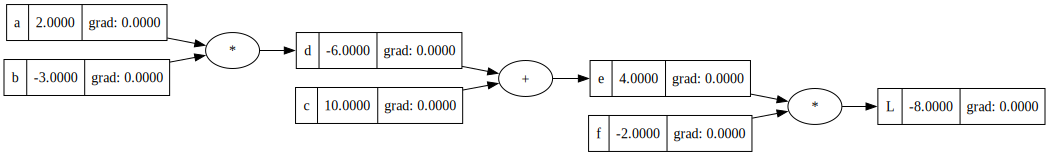

In [264]:
draw_dot(L)

We need to calculate derivative of L w.r.t all the intermediate variable

## Manual estimation of gradient

Inline gradient check. Deriving all the gradient using backpropogation steps, then numerical gradient is only estimating it using small step size.

In [265]:
def lol():
    """Function for inline gradient checking"""
    h = Value(0.001)
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")

    d = a*b; d.label = "d"
    e = d+c; e.label = "e"
    f = Value(-2.0, label="f")
    L1 = e*f; L1.label="L"
    a = Value(2.0, label="a")
    a += h
    b = Value(-3.0, label="b")
    # b += h
    c = Value(10.0, label="c")
    # c += h 
    d = a*b; d.label = "d"
    # d += h
    e = d+c; e.label = "e"
    # e += h
    f = Value(-2.0, label="f")
    # f +=h
    L2 = e*f; L2.label="L"
    # L2 += h
    return (L2 - L1)/h
    
lol()

Value(data=6.000000000000227)

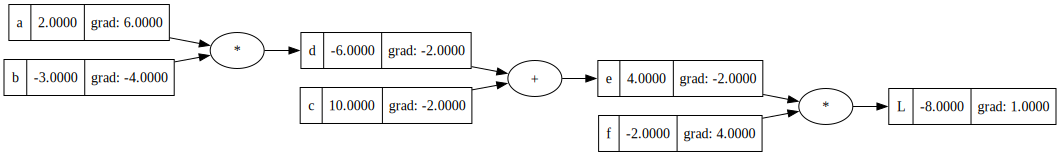

In [266]:
L.grad = 1.0
f.grad = 4.0
e.grad = -2.0
d.grad = -2.0      # dL/de*de/dd
c.grad = -2.0     
b.grad = -4.0      # dL/de*de/dd*dd/db
a.grad = 6.0
draw_dot(L)

### Quick Findings

- Addition operation acts like a routing or distributing operation for the gradient
- Local derivative of the sum is same as gradient of the parent . Local node knows about the local influence
- Multiplication operation inverts with gradient on same level before multiplying with the next in line gradient
- We can imagine gradient to be flowing backward through the graph and a plus node will just distribute it to parent nodes or routes the gradient as local derivative on the plus nodes are just 1.0
- Output produced some operation
- Pointer to the nodes/ children of the operation/ 

- Manual Backpropogation 
    - Iterate through nodes 1 by 1
    - Locally apply the chain rule by multiplying gradient of parent with local derivatives of children with respect to parent node. 
        - For addition this local derivative is just 1, This basically means "+" operation routes the gradient to children node in backpropogation
        - For multiplication this local derivative is the value of other child node  

- Go through recursively and multiply on the derivative => Back propogation 
- So one definition of backpropogation could be - Recursive application of chain rule, applied backwards through the computation graph
- Sidenote  to fix terminal launching with vscode and terminal app on mac - "sudo sysctl -w kern.tty.ptmx_max=768"

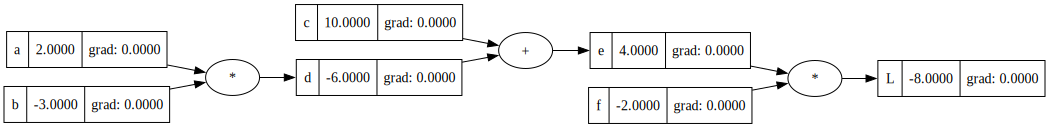

In [267]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")

d = a*b; d.label = "d"
e = d+c; e.label = "e"
f = Value(-2.0, label="f")
L = e*f; L.label="L"
draw_dot(L)

In [268]:
s = L._prev
# a = list(L._prev)
# a[0]
# a[1]

### Rudimentary back prop implementation

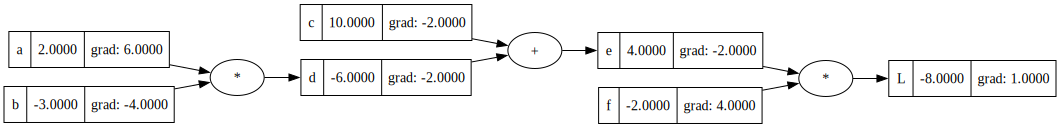

In [269]:
def backprop_m(root):
    children = list(root._prev)
    for i, elem in enumerate(children):
        if root._op == "+":
            # print(elem, "+")
            elem.grad = root.grad
            backprop_m(elem)
        elif root._op == "*":
            # print(elem, "*")
            if i == 0:
                elem.grad = root.grad*children[1].data
                backprop(elem)
            else:
                elem.grad = root.grad*children[0].data
                backprop_m(elem)
        elif root._op == "tanh":
            ''' Derivative of tanh is 1- tanh(x)^2 as defined [here](https://socratic.org/questions/what-is-the-derivative-of-tanh-x)'''
            elem.grad = 1- root.data**2
            backprop_m(elem)
        else:
            print("op not defined")

L.grad = 1.0
backprop_m(L)
        
draw_dot(L)

In [270]:
a, b
a.data // b.data
a // b

Value(data=-1.0)

### Preview of Single Optimization Step

Objective is to nudge our inputs slightly to make L go up.

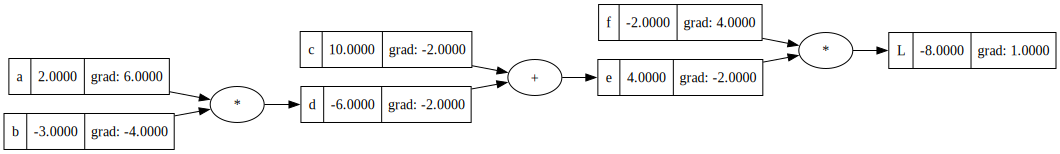

In [271]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
f = Value(-2.0, label="f")
d = a*b; d.label = "d"
e = d+c; e.label = "e"
L = e*f; L.label="L"

L.grad = 1.0
backprop_m(L)
draw_dot(L)

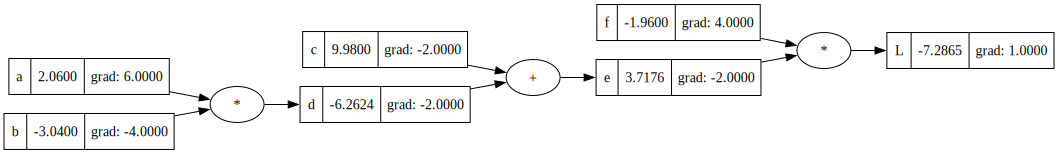

In [272]:
step_size = 0.01

a.data += step_size*a.grad
b.data += step_size*b.grad
c.data += step_size*c.grad
f.data += step_size*f.grad

# Rerunning forward pass
d_grad = d.grad
d = a*b; d.label = "d"
d.grad = d_grad
e_grad = e.grad
e = d+c; e.label = "e"
e.grad = e_grad
L_grad = L.grad
L = e*f; L.label="L"
L.grad = L_grad
draw_dot(L)

Some things to ponder

- Do we need to preserve gradient during forward pass?? 
- Perhaps we should add this grad preservation logic directly into value class. 
- Since we are reinitializing the objects here gradients are also reinitialized to zero. Perhaps another forward pass function might be useful which works on exactly same computational graph for L

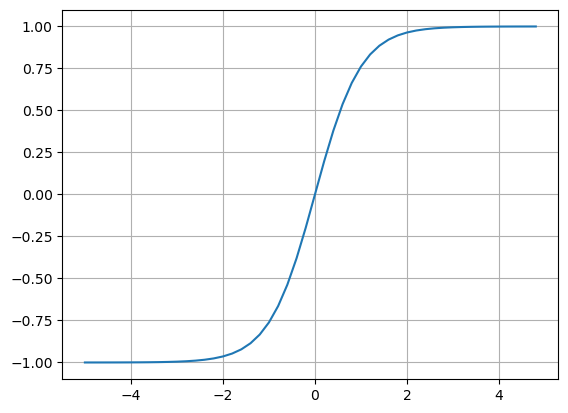

In [273]:
xs = np.arange(-5, 5, 0.2)
ys = np.tanh(xs)
plt.plot(xs, ys)
plt.grid(True)

### Back Propogation through neuron

![MLP](https://www.researchgate.net/publication/364814302/figure/fig5/AS:11431281092677232@1666928276027/Neural-net-Structure-with-an-Activation-Function-Source-CS231n-Stanford-2017.png)

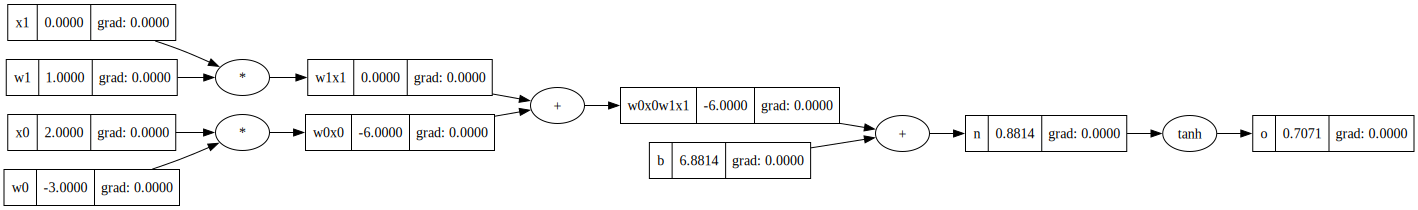

In [274]:
#Inputs x1, x2
x0 = Value(2.0, label="x0")
x1 = Value(0.0, label="x1")
# x2 = Value(-2.0, label="x2")

# Weights w1,w2
w0 = Value(-3.0, label="w0")
w1 = Value(1.0, label="w1")
# w2 = Value(1.0, label="w2")

# Bias of the neuron . A weird value is chosen here to make derivative values good 
b = Value(6.881375870195432, label="b")

w0x0 = w0*x0; w0x0.label = "w0x0"
w1x1 = w1*x1; w1x1.label = "w1x1"
# w2x2 = w2*x2; w2x2.label = "w2x2"

w0x0w1x1 = w0x0+w1x1;  w0x0w1x1.label = 'w0x0w1x1'
n = w0x0w1x1+b; n.label = "n"
o = n.tanh(); o.label = "o"
draw_dot(o)

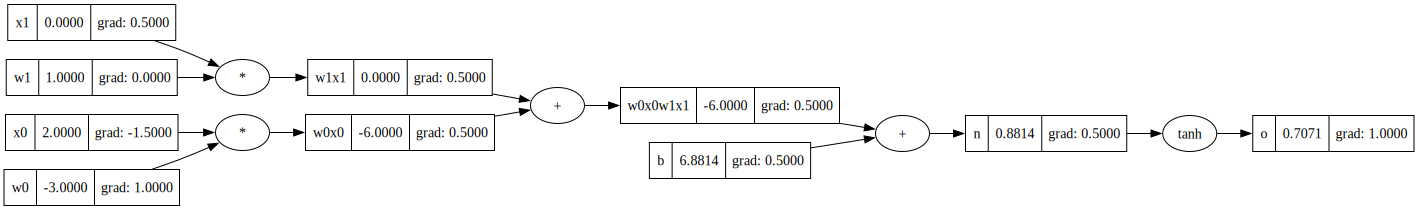

In [275]:
o.grad = 1.0
backprop_m(o)
draw_dot(o)

For x1 == 0 , it will weights w1 will have no influence on final output as intuitively anything multiplied by zero will always give zero. Hence gradient of w1 is zero.

In [276]:
def lol():
    """Function for inline gradient checking"""
    h = Value(0.001)
    #Inputs x1, x2
    x0 = Value(2.0, label="x0")
    x1 = Value(0.0, label="x1")
    # x2 = Value(-2.0, label="x2")

    # Weights w1,w2
    w0 = Value(-3.0, label="w0")
    w1 = Value(1.0, label="w1")
    # w2 = Value(1.0, label="w2")

    # Bias of the neuron . A weird value is chosen here to make derivative values good 
    b = Value(6.881375870195432, label="b")

    w0x0 = w0*x0; w0x0.label = "w0x0"
    w1x1 = w1*x1; w1x1.label = "w1x1"
    # w2x2 = w2*x2; w2x2.label = "w2x2"

    w0x0w1x1 = w0x0+w1x1;  w0x0w1x1.label = 'w0x0w1x1'
    n = w0x0w1x1+b; n.label = "n"
    L1 = n.tanh(); L1.label="L"
    x0 = Value(2.0, label="x0")
    # x0 += h
    x1 = Value(0.0, label="x1")
    # x1 +=h
    # x2 = Value(-2.0, label="x2")

    # Weights w1,w2
    w0 = Value(-3.0, label="w0")
    w0 += h
    w1 = Value(1.0, label="w1")
    # w2 = Value(1.0, label="w2")

    # Bias of the neuron . A weird value is chosen here to make derivative values good 
    b = Value(6.881375870195432, label="b")
    # b += h

    w0x0 = w0*x0; w0x0.label = "w0x0"
    w1x1 = w1*x1; w1x1.label = "w1x1"
    # w2x2 = w2*x2; w2x2.label = "w2x2"

    w0x0w1x1 = w0x0+w1x1;  w0x0w1x1.label = 'w0x0w1x1'
    n = w0x0w1x1+b; n.label = "n"
    # n += h
    L2 = n.tanh(); L2.label="L"
    # L2 += h
    return (L2 - L1)/h

lol()

Value(data=0.9985832274368445)

## Graph Backward Propogation

We implement an algoritm after implementing how local derivative are linked to out node and implementing the same in `Value` class

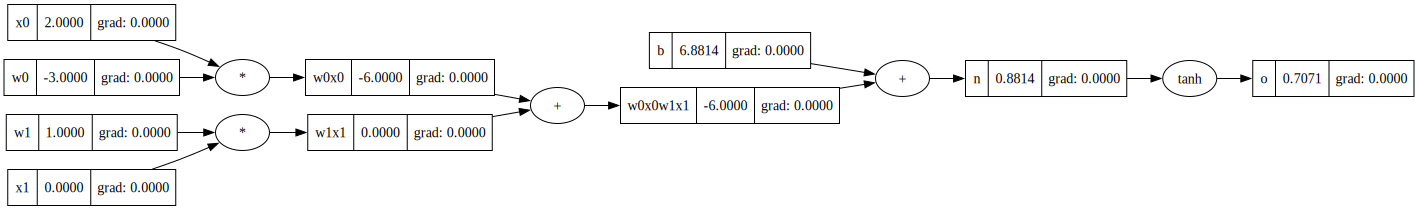

In [277]:
x0 = Value(2.0, label="x0")
x1 = Value(0.0, label="x1")
# x2 = Value(-2.0, label="x2")

# Weights w1,w2
w0 = Value(-3.0, label="w0")
w1 = Value(1.0, label="w1")
# w2 = Value(1.0, label="w2")

# Bias of the neuron . A weird value is chosen here to make derivative values good 
b = Value(6.881375870195432, label="b")

w0x0 = w0*x0; w0x0.label = "w0x0"
w1x1 = w1*x1; w1x1.label = "w1x1"
# w2x2 = w2*x2; w2x2.label = "w2x2"

w0x0w1x1 = w0x0+w1x1;  w0x0w1x1.label = 'w0x0w1x1'
n = w0x0w1x1+b; n.label = "n"
o = n.tanh(); o.label="o"
draw_dot(o)

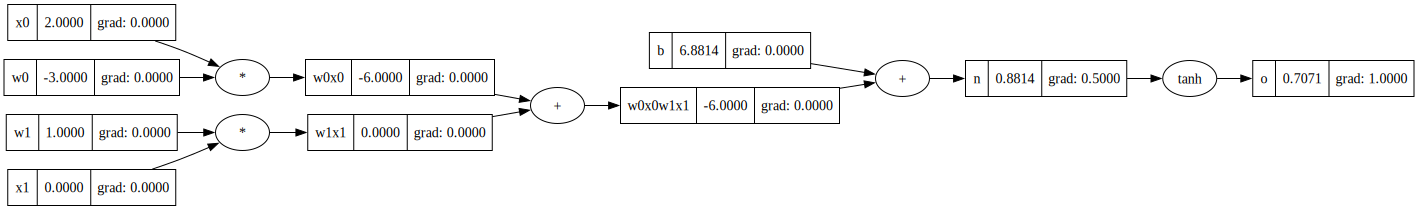

In [278]:
o.grad = 1.0
o._backward()
draw_dot(o)

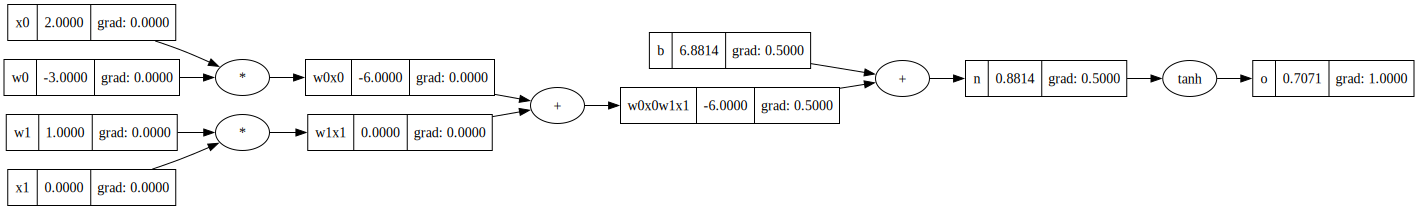

In [279]:
n._backward()
draw_dot(o)

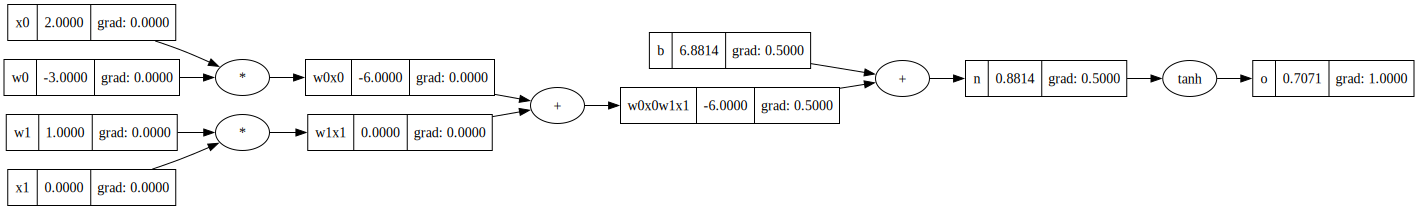

In [280]:
b._backward()
draw_dot(o)

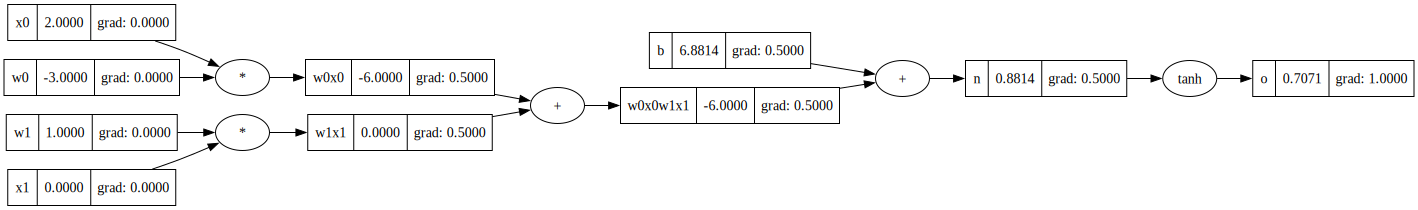

In [281]:
w0x0w1x1._backward()
draw_dot(o)

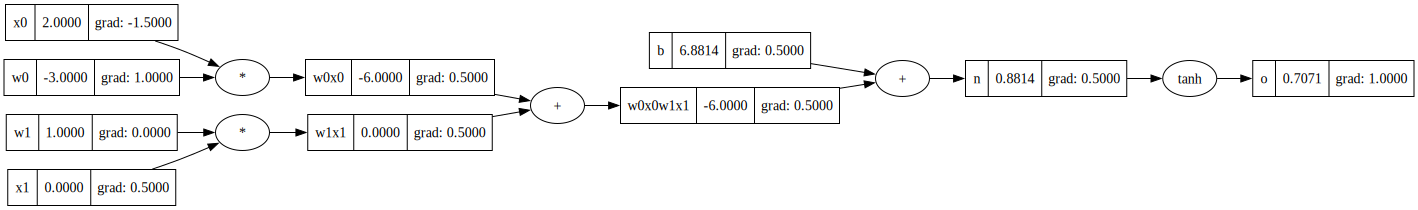

In [282]:
w1x1._backward()
w0x0._backward()
draw_dot(o)

Below is my implementation of backprop leveraging backward

In [283]:
#| export
def backprop_r(root):
    ''' Backpropogation leveraging the _backward method in graph'''
    root._backward()
    for i in root._prev:
        i._backward()
        backprop_r(i)

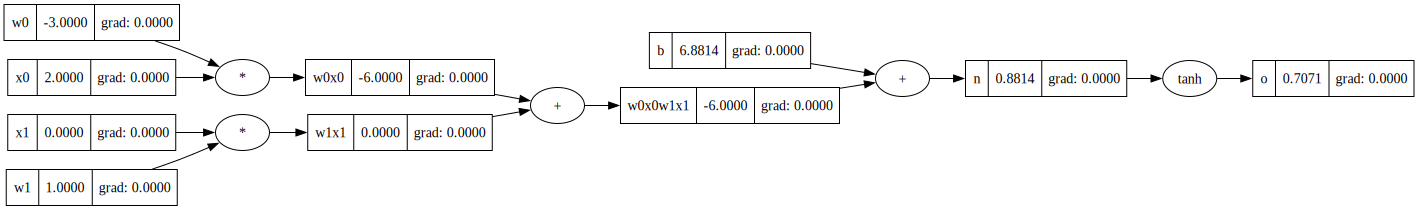

In [284]:
x0 = Value(2.0, label="x0")
x1 = Value(0.0, label="x1")
# x2 = Value(-2.0, label="x2")

# Weights w1,w2
w0 = Value(-3.0, label="w0")
w1 = Value(1.0, label="w1")
# w2 = Value(1.0, label="w2")

# Bias of the neuron . A weird value is chosen here to make derivative values good 
b = Value(6.881375870195432, label="b")

w0x0 = w0*x0; w0x0.label = "w0x0"
w1x1 = w1*x1; w1x1.label = "w1x1"
# w2x2 = w2*x2; w2x2.label = "w2x2"

w0x0w1x1 = w0x0+w1x1;  w0x0w1x1.label = 'w0x0w1x1'
n = w0x0w1x1+b; n.label = "n"
o = n.tanh(); o.label="o"
draw_dot(o)

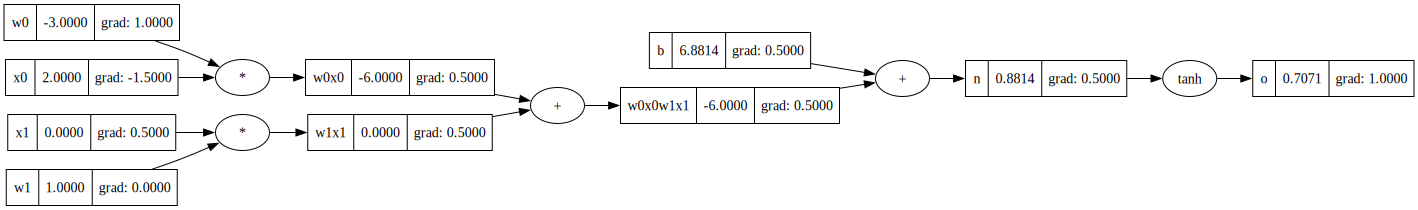

In [285]:
o.grad=1.0
backprop_r(o)
draw_dot(o)

### Topological Sort

![Topological Sort](https://miro.medium.com/v2/resize:fit:720/format:webp/1*uMg_ojFXts2WZSjcZe4oRQ.png)

Some comments and intuitions

- We never want to call backward for any node before we have done backward on all the nodes after it [Full dependencies, anything that it depends on has to propogate to it]
- This can be achieved through something called topological sort [ Algorithm for layout graph from Left to Right]
- [Topological sort](https://medium.com/@konduruharish/topological-sort-in-typescript-and-c-6d5ecc4bad95) is only possible in a DAG ( i.e. there are no loops in the graph)
- A question to ponder _"Why do topological sort instead of simple recursive implementation like above?"_

In [286]:
#| exports
def topo_sort(o):
    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(o)
    return topo, visited

In the implementation of topo_sort. A node only adds itself _once_ to the topo list after all it's children are added. That guarantees invariance is maintained.

In [287]:
topo_sort(o)

([Value(x0|data=2.0),
  Value(w0|data=-3.0),
  Value(w0x0|data=-6.0),
  Value(w1|data=1.0),
  Value(x1|data=0.0),
  Value(w1x1|data=0.0),
  Value(w0x0w1x1|data=-6.0),
  Value(b|data=6.881375870195432),
  Value(n|data=0.8813758701954324),
  Value(o|data=0.7071079227726492)],
 {Value(b|data=6.881375870195432),
  Value(n|data=0.8813758701954324),
  Value(o|data=0.7071079227726492),
  Value(w0x0w1x1|data=-6.0),
  Value(w0x0|data=-6.0),
  Value(w0|data=-3.0),
  Value(w1x1|data=0.0),
  Value(w1|data=1.0),
  Value(x0|data=2.0),
  Value(x1|data=0.0)})

In [288]:
topo_sort(n)

([Value(x0|data=2.0),
  Value(w0|data=-3.0),
  Value(w0x0|data=-6.0),
  Value(w1|data=1.0),
  Value(x1|data=0.0),
  Value(w1x1|data=0.0),
  Value(w0x0w1x1|data=-6.0),
  Value(b|data=6.881375870195432),
  Value(n|data=0.8813758701954324)],
 {Value(b|data=6.881375870195432),
  Value(n|data=0.8813758701954324),
  Value(w0x0w1x1|data=-6.0),
  Value(w0x0|data=-6.0),
  Value(w0|data=-3.0),
  Value(w1x1|data=0.0),
  Value(w1|data=1.0),
  Value(x0|data=2.0),
  Value(x1|data=0.0)})

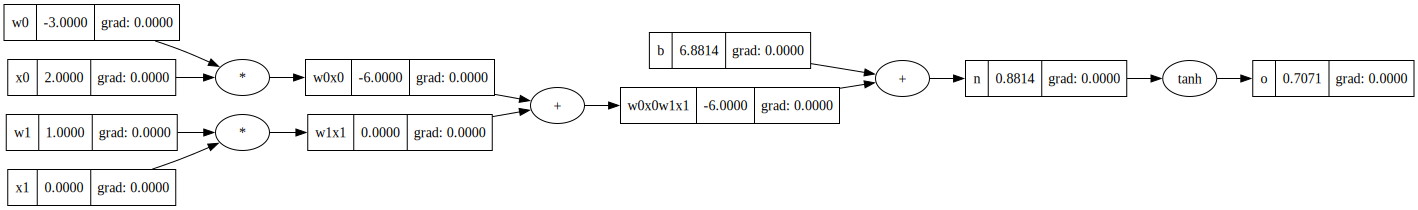

In [289]:
#| hide
x0 = Value(2.0, label="x0")
x1 = Value(0.0, label="x1")
# x2 = Value(-2.0, label="x2")

# Weights w1,w2
w0 = Value(-3.0, label="w0")
w1 = Value(1.0, label="w1")
# w2 = Value(1.0, label="w2")

# Bias of the neuron . A weird value is chosen here to make derivative values good 
b = Value(6.881375870195432, label="b")

w0x0 = w0*x0; w0x0.label = "w0x0"
w1x1 = w1*x1; w1x1.label = "w1x1"
# w2x2 = w2*x2; w2x2.label = "w2x2"

w0x0w1x1 = w0x0+w1x1;  w0x0w1x1.label = 'w0x0w1x1'
n = w0x0w1x1+b; n.label = "n"
o = n.tanh(); o.label="o"
draw_dot(o)

Back prop implementation below needs to be added to the `Value` class

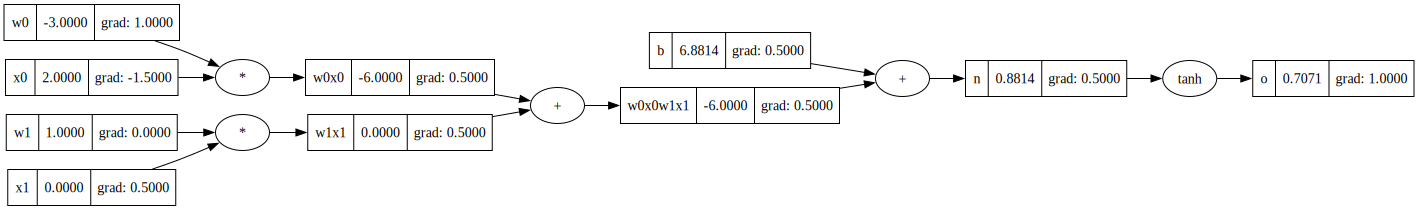

In [290]:
o.grad = 1.0
topo, _ = topo_sort(o)
for node in reversed(topo):
    node._backward()
draw_dot(o)
# topo

In [296]:
#| hide
x0 = Value(2.0, label="x0")
x1 = Value(0.0, label="x1")
# x2 = Value(-2.0, label="x2")

# Weights w1,w2
w0 = Value(-3.0, label="w0")
w1 = Value(1.0, label="w1")
# w2 = Value(1.0, label="w2")

# Bias of the neuron . A weird value is chosen here to make derivative values good 
b = Value(6.881375870195432, label="b")

w0x0 = w0*x0; w0x0.label = "w0x0"
w1x1 = w1*x1; w1x1.label = "w1x1"
# w2x2 = w2*x2; w2x2.label = "w2x2"

w0x0w1x1 = w0x0+w1x1;  w0x0w1x1.label = 'w0x0w1x1'
n = w0x0w1x1+b; n.label = "n"
o = n.tanh(); o.label="o"

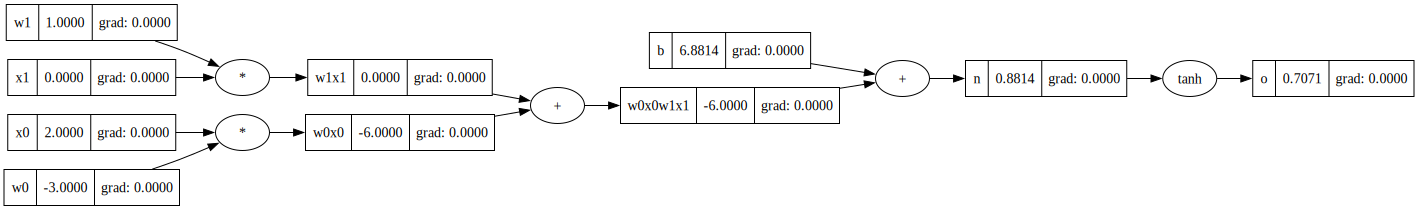

In [297]:

draw_dot(o)

In [298]:
o.backward()

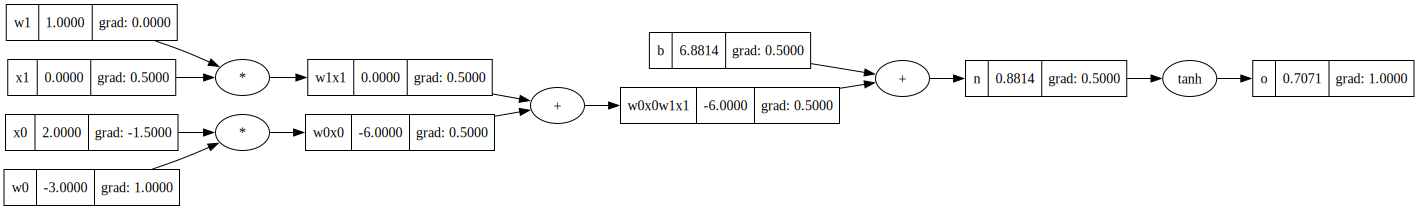

In [299]:
draw_dot(o)

In [301]:
#| hide
import nbdev; nbdev.nbdev_export()